In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
df = spark.read.csv("bank.csv", inferSchema=True , header=True) 

In [4]:
df.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|    1042|       1|   -1|       0|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|    1467|       1|   -1|       0|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|    1389|       1|   -1|       0|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|     579|       1|   -1|       0|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  no|unknown|     673|       2|   -1|       0|    yes|
| 42| management|  single| tertiary|     no|      0|    yes| yes|unknown|     56

In [5]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- deposit: string (nullable = true)



In [7]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [9]:
catcols = ['job','marital','education','default',
           'housing','loan','contact']

num_cols = ['balance', 'duration','campaign','pdays','previous',]
labelCol = 'deposit'

data = get_dummy(df,catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(26,[3,11,13,16,1...|  yes|
|(26,[3,11,13,16,1...|  yes|
|(26,[2,11,13,16,1...|  yes|
|(26,[4,11,13,16,1...|  yes|
|(26,[3,11,14,16,1...|  yes|
+--------------------+-----+
only showing top 5 rows



In [10]:
from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(26,[3,11,13,16,1...|  yes|         1.0|
|(26,[3,11,13,16,1...|  yes|         1.0|
|(26,[2,11,13,16,1...|  yes|         1.0|
|(26,[4,11,13,16,1...|  yes|         1.0|
|(26,[3,11,14,16,1...|  yes|         1.0|
+--------------------+-----+------------+
only showing top 5 rows



In [11]:
from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(26,[3,11,13,16,1...|  yes|(26,[3,11,13,16,1...|
|(26,[3,11,13,16,1...|  yes|(26,[3,11,13,16,1...|
|(26,[2,11,13,16,1...|  yes|(26,[2,11,13,16,1...|
|(26,[4,11,13,16,1...|  yes|(26,[4,11,13,16,1...|
|(26,[3,11,14,16,1...|  yes|(26,[3,11,14,16,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [12]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+-------------------------------------------------------------------------------------------+-----+
|features                                                                                   |label|
+-------------------------------------------------------------------------------------------+-----+
|(26,[0,11,13,16,17,18,19,21,22,23,24],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,-382.0,644.0,12.0,-1.0])|yes  |
|(26,[0,11,13,16,17,18,19,21,22,23,24],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,37.0,84.0,11.0,-1.0])   |no   |
|(26,[0,11,13,16,17,18,19,21,22,23,24],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,80.0,155.0,3.0,-1.0])   |no   |
|(26,[0,11,13,16,17,18,19,21,22,23,24],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,99.0,15.0,5.0,-1.0])    |no   |
|(26,[0,11,13,16,17,18,19,21,22,23,24],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,149.0,1222.0,2.0,-1.0]) |yes  |
+-------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+--------------------------------------------------------------------------

In [13]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [17]:
# Convert indexed labels back to original labels.
from pyspark.ml.feature import IndexToString
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [19]:
# Chain indexers and tree in a Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

In [20]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [21]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(26,[0,11,13,16,1...|   no|            no|
|(26,[0,11,13,16,1...|   no|            no|
|(26,[0,11,13,16,1...|  yes|           yes|
|(26,[0,11,13,16,1...|  yes|            no|
|(26,[0,11,13,16,1...|   no|           yes|
+--------------------+-----+--------------+
only showing top 5 rows



In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.209038


In [23]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|2.838489923360772E-4|0.001588814744200...|
|2.838489923360772E-4|0.003495392437241...|
|8.515469770082316E-4|0.004766444232602479|
|8.515469770082316E-4| 0.00667302192564347|
+--------------------+--------------------+
only showing top 5 rows

areaUnderROC: 0.8769102419336883


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
##print(class_name)
class_temp

['no', 'yes']

In [34]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[1907,  443],
       [ 496, 1646]])

Confusion matrix, without normalization
[[1907  443]
 [ 496 1646]]


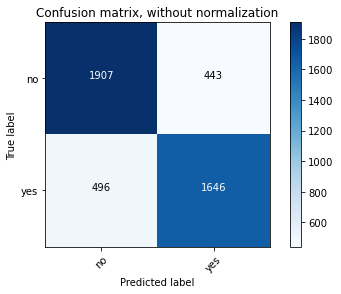

In [35]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.81148936 0.18851064]
 [0.23155929 0.76844071]]


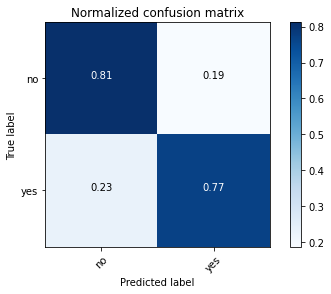

In [36]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Decision Tree

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier

# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [38]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [39]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

In [40]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [41]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(26,[0,11,13,16,1...|   no|            no|
|(26,[0,11,13,16,1...|   no|            no|
|(26,[0,11,13,16,1...|  yes|           yes|
|(26,[0,11,13,16,1...|  yes|            no|
|(26,[0,11,13,16,1...|   no|           yes|
+--------------------+-----+--------------+
only showing top 5 rows



In [42]:
#Evaluuation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.208593
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e0cb96ff06ab, depth=5, numNodes=33, numClasses=2, numFeatures=26


In [44]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[1800,  550],
       [ 387, 1755]])

Confusion matrix, without normalization
[[1800  550]
 [ 387 1755]]


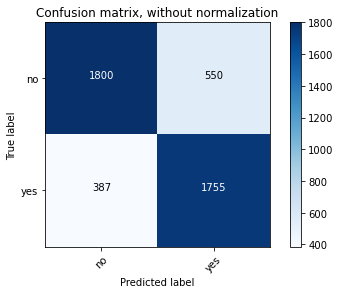

In [46]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.76595745 0.23404255]
 [0.18067227 0.81932773]]


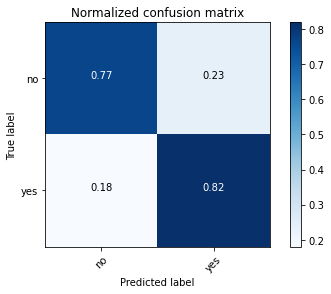

In [47]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Fit Random Forest Classification Model

In [48]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)


In [49]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [50]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

In [51]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [52]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)


+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(26,[0,11,13,16,1...|   no|            no|
|(26,[0,11,13,16,1...|   no|            no|
|(26,[0,11,13,16,1...|  yes|           yes|
|(26,[0,11,13,16,1...|  yes|            no|
|(26,[0,11,13,16,1...|   no|           yes|
+--------------------+-----+--------------+
only showing top 5 rows



In [53]:
#Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.199466
RandomForestClassificationModel: uid=RandomForestClassifier_3a017945cc9b, numTrees=10, numClasses=2, numFeatures=26


In [55]:
#Visualize
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[1852,  498],
       [ 398, 1744]])

Confusion matrix, without normalization
[[1852  498]
 [ 398 1744]]


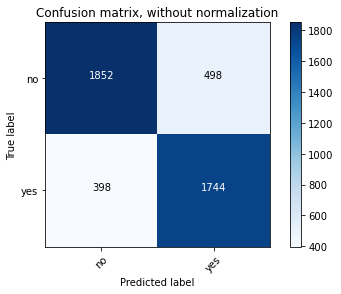

In [56]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.78808511 0.21191489]
 [0.18580766 0.81419234]]


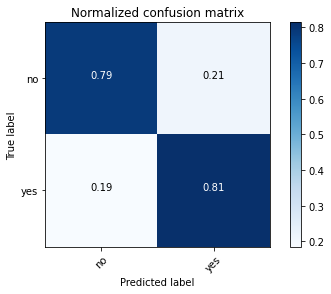

In [58]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Gradient Boosting

In [59]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [60]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [61]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt,labelConverter])

In [62]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [63]:

# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(26,[0,11,13,16,1...|   no|            no|
|(26,[0,11,13,16,1...|   no|            no|
|(26,[0,11,13,16,1...|  yes|           yes|
|(26,[0,11,13,16,1...|  yes|            no|
|(26,[0,11,13,16,1...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



In [64]:
#Evaluation
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.191451
GBTClassificationModel: uid = GBTClassifier_464b0509d780, numTrees=20, numClasses=2, numFeatures=26


In [65]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[1869,  481],
       [ 379, 1763]])

Confusion matrix, without normalization
[[1869  481]
 [ 379 1763]]


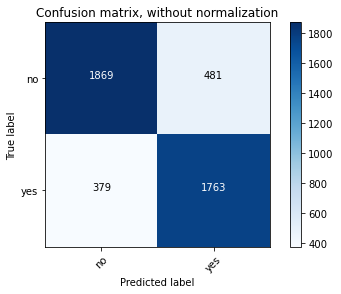

In [66]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.79531915 0.20468085]
 [0.17693744 0.82306256]]


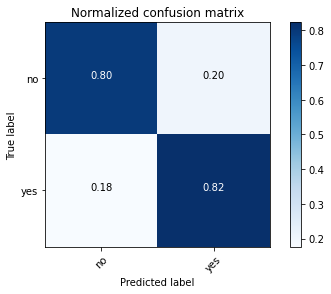

In [67]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()